# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
#import shap

In [2]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv", dtype={
    'cd_msa': str,
    'zipcode': str,
    'id_loan_rr': str, 
    'rr_ind':str})
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 1. Get general info

In [3]:
# For general info 
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            200000 non-null  int64  
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  object 
 5   mi_pct          200000 non-null  int64  
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            200000 non-null  int64  
 9   dti             200000 non-null  int64  
 10  orig_upb        200000 non-null  int64  
 11  ltv             200000 non-null  int64  
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

## 2. Filter Active Loans and Check Target Distribution

In [4]:
# Filter out active loans (only keep 'default' and 'prepaid')
d_filtered = d[d['loan_status'].isin(['default', 'prepaid'])].copy()
d_filtered['loan_status'] = d_filtered['loan_status'].map({'default': 1, 'prepaid': 0})
print("Data shape after filtering active loans:", d_filtered.shape)

# Check target distribution
target_dist = d_filtered['loan_status'].value_counts(normalize=True) * 100
print("\nTarget Distribution (%):")
print(target_dist)

Data shape after filtering active loans: (126705, 33)

Target Distribution (%):
loan_status
0    99.411231
1     0.588769
Name: proportion, dtype: float64


## 3. Find Missing Values and Drop Useless Features

In [5]:
# Replace missing values with NaN
missing_values = {
    'fico': [9999],
    'flag_fthb': ['9'],
    'mi_pct': [999],
    'cnt_units': [99],
    'occpy_sts': ['9'],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'property_val': [9],
    'mi_cancel_ind': ['7', '9'],
    'flag_sc': ['N'],
    'rr_ind': ['N'],
}

for col, codes in missing_values.items():
    d_filtered[col] = d_filtered[col].replace(codes, np.nan)

missing_values = d_filtered.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(d_filtered)) * 100
print("Missing Values in Training Data:")
print(pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percent})
      [missing_values > 0])


Missing Values in Training Data:
               Missing Count  Percentage (%)
id_loan_rr            125406       98.974784
rr_ind                125406       98.974784
flag_sc               121241       95.687621
program_ind           116496       91.942702
mi_cancel_ind          87026       68.683951
cd_msa                 11294        8.913618
dti                     1304        1.029162
property_val              94        0.074188
fico                      24        0.018942
ltv                        1        0.000789
mi_pct                     1        0.000789
cltv                       1        0.000789


In [6]:
missing_pct = d_filtered.isna().mean()
high_missing_cols = missing_pct[missing_pct > 0.9].index.tolist()
print("Columns with >90% missing values:", high_missing_cols)

# Check for columns with all same non-NaN values
constant_cols = []
for col in d_filtered.columns:
    if d_filtered[col].nunique(dropna=True) == 1:
        constant_cols.append(col)

print("Columns with constant values:", constant_cols)

ide_cols = ['id_loan', 'seller_name', 'servicer_name']

cols_to_drop = list(set(constant_cols + high_missing_cols + ide_cols))
print("Columns to drop:", cols_to_drop)

d_filtered = d_filtered.drop(columns=cols_to_drop, errors='ignore')

Columns with >90% missing values: ['flag_sc', 'id_loan_rr', 'program_ind', 'rr_ind']
Columns with constant values: ['ppmt_pnlty', 'prod_type', 'flag_sc', 'rr_ind', 'io_ind']
Columns to drop: ['flag_sc', 'prod_type', 'seller_name', 'rr_ind', 'program_ind', 'id_loan', 'servicer_name', 'io_ind', 'id_loan_rr', 'ppmt_pnlty']


## 4. Train-Test Split

In [7]:
# Split data before EDA to avoid data leakage
X = d_filtered.drop('loan_status', axis=1)
y = d_filtered['loan_status']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

In [8]:
# Example for numeric columns
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv']
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])


ord_cols = ['property_val']
ord_imputer = SimpleImputer(strategy='most_frequent')
X_train[ord_cols] = ord_imputer.fit_transform(X_train[ord_cols])
X_test[ord_cols] = ord_imputer.transform(X_test[ord_cols])


# Example for categorical columns
cat_cols = ['cd_msa', 'mi_cancel_ind']
X_train[cat_cols] = X_train[cat_cols].fillna('Unknown')
X_test[cat_cols] = X_test[cat_cols].fillna('Unknown')


## 5. Feature Engineering

In [9]:

# Convert date columns to datetime and calculate loan term
X_train['dt_first_pi'] = pd.to_datetime(X_train['dt_first_pi'], format='%Y%m')
X_train['dt_matr'] = pd.to_datetime(X_train['dt_matr'], format='%Y%m')
X_train['loan_age_months'] = (X_train['dt_matr'] - X_train['dt_first_pi']).dt.days // 30

# Repeat for test data
X_test['dt_first_pi'] = pd.to_datetime(X_test['dt_first_pi'], format='%Y%m')
X_test['dt_matr'] = pd.to_datetime(X_test['dt_matr'], format='%Y%m')
X_test['loan_age_months'] = (X_test['dt_matr'] - X_test['dt_first_pi']).dt.days // 30

# Drop original date columns
X_train = X_train.drop(columns=['dt_first_pi', 'dt_matr'])
X_test = X_test.drop(columns=['dt_first_pi', 'dt_matr'])

# Combine training data for EDA
train_df = pd.concat([X_train, y_train], axis=1)
print("\nTraining data shape:", train_df.shape)



Training data shape: (101364, 22)


## 5. Exploratory Data Analysis (EDA)

### 5.1 Numerical Features Analysis

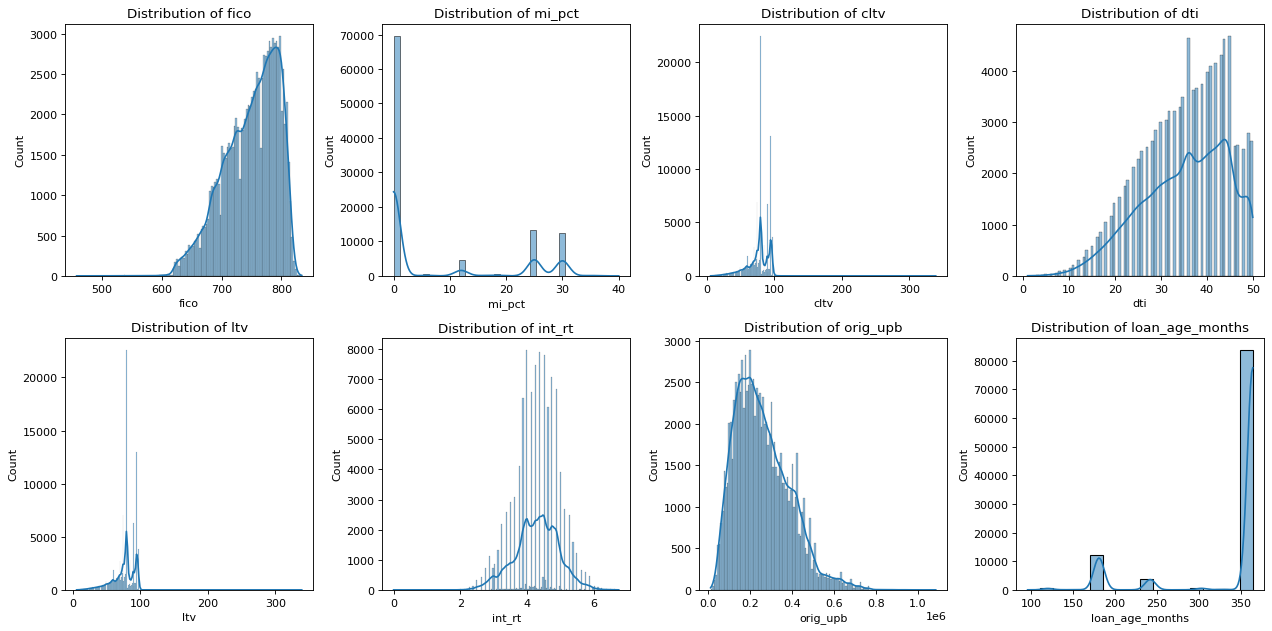

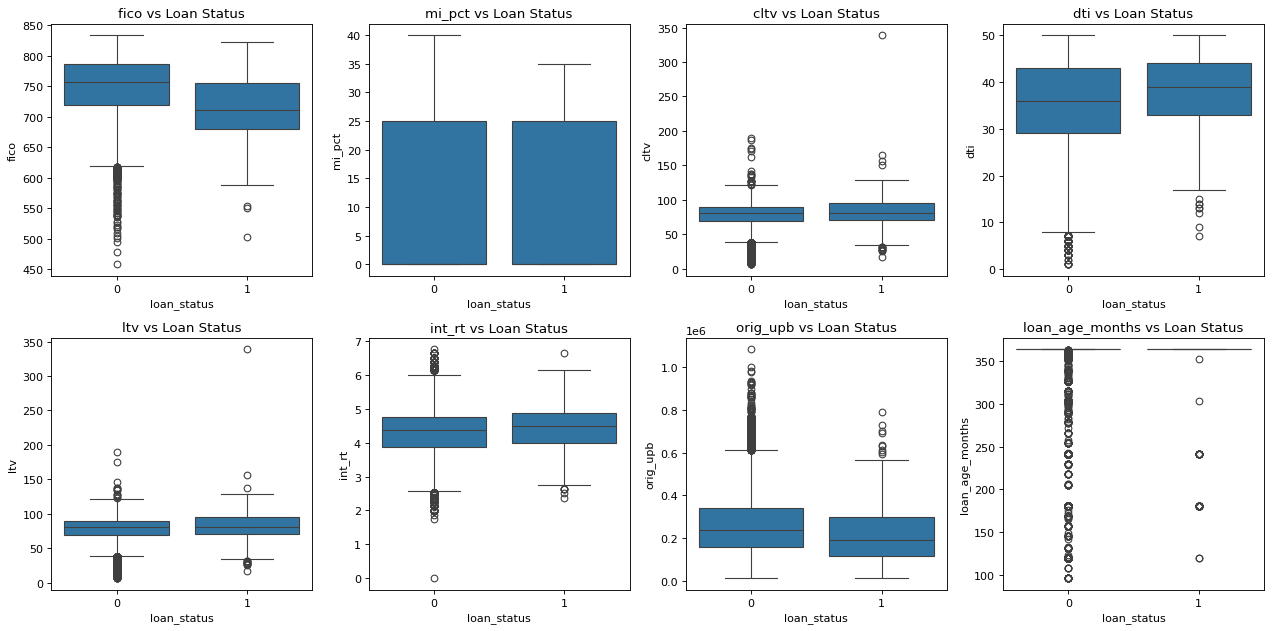

In [10]:
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv', 'int_rt', 'orig_upb', 'loan_age_months']

# Distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], ax=axes[i//4, i%4], kde=True)
    axes[i//4, i%4].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# Relationships with Target
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(num_cols):
    sns.boxplot(x='loan_status', y=col, data=train_df, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'{col} vs Loan Status')
plt.tight_layout()
plt.show()

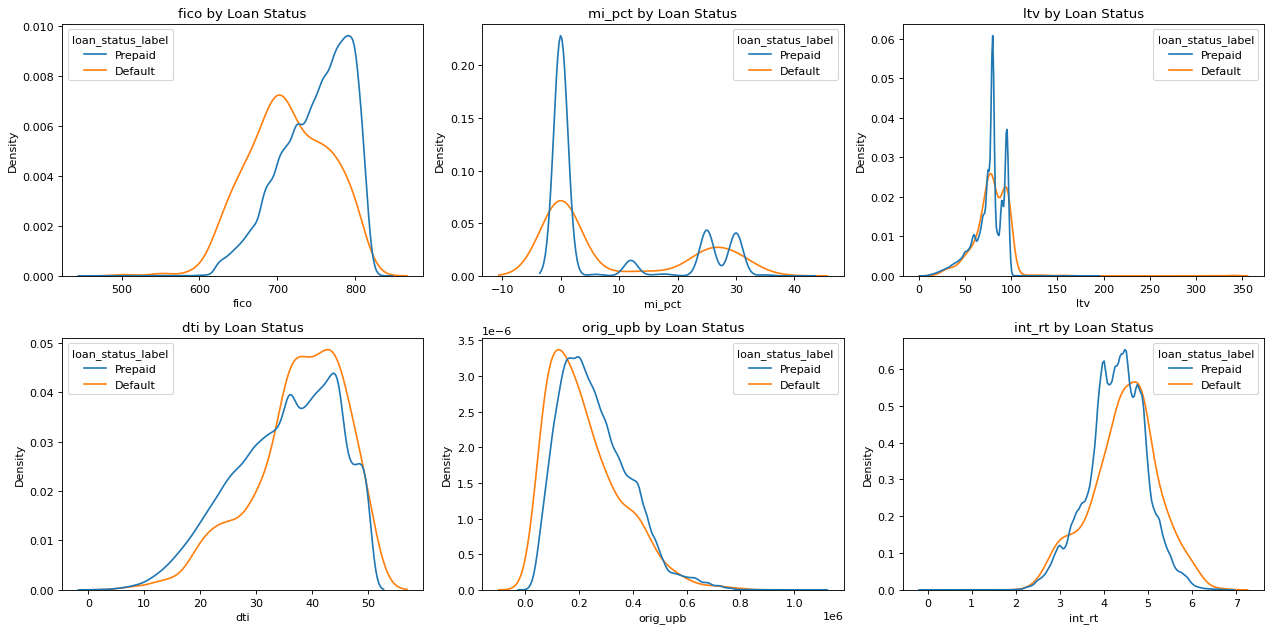

In [11]:
# Numerical feature distribution comparison by loan status
num_vars = ['fico', 'mi_pct', 'ltv', 'dti', 'orig_upb', 'int_rt']
train_df['loan_status_label'] = train_df['loan_status'].map({0: 'Prepaid', 1: 'Default'})

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    if col in train_df.columns:
        sns.kdeplot(data=train_df, x=col, hue='loan_status_label', ax=axes[i], common_norm=False)
        axes[i].set_title(f'{col} by Loan Status')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

# Remove extra subplot if num_vars < total subplots
for j in range(len(num_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 5.2 Categorical Features Analysis

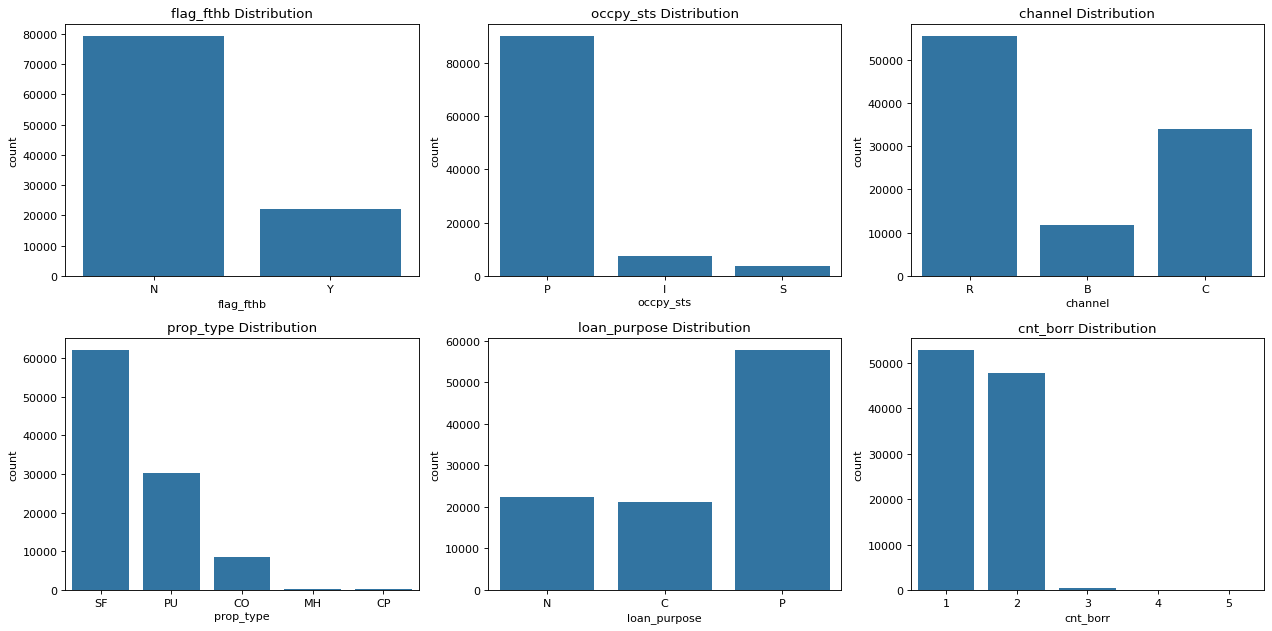

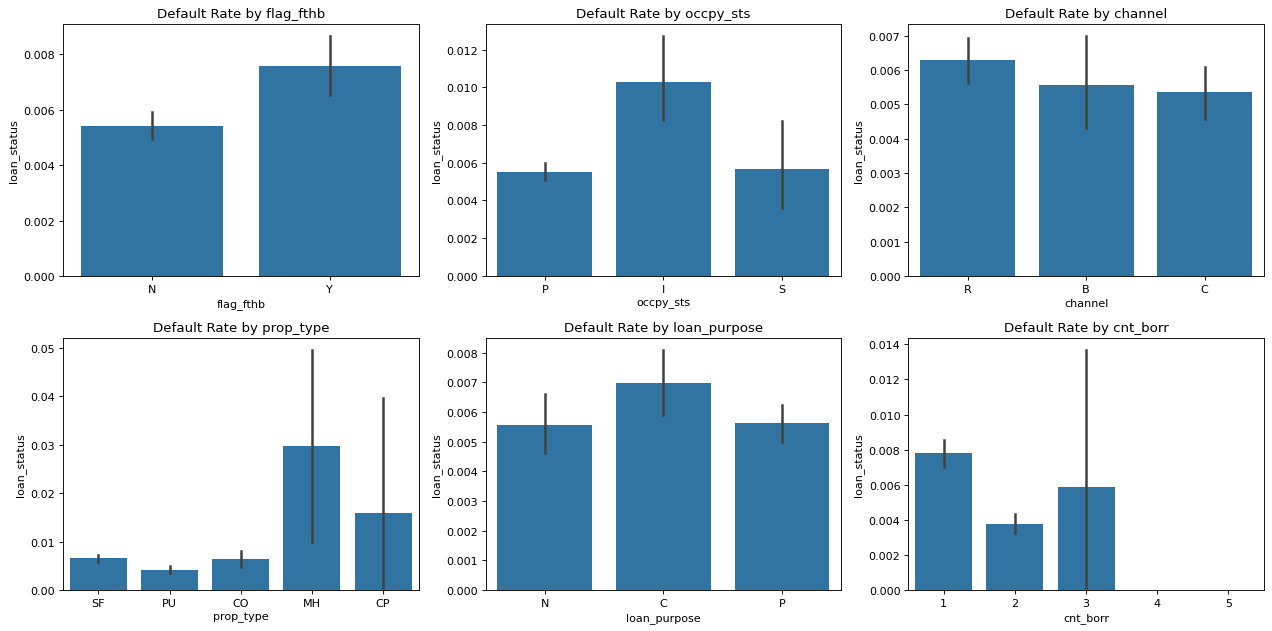

In [12]:
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr']

# Frequency plots
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train_df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} Distribution')
    axes[i//3, i%3].tick_params(axis='x')
plt.tight_layout()
plt.show()

# Relationship with Target
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='loan_status', data=train_df, ax=axes[i//3, i%3], estimator=np.mean)
    axes[i//3, i%3].set_title(f'Default Rate by {col}')
    axes[i//3, i%3].tick_params(axis='x')
plt.tight_layout()
plt.show()


### 5.3 Correlation Analysis

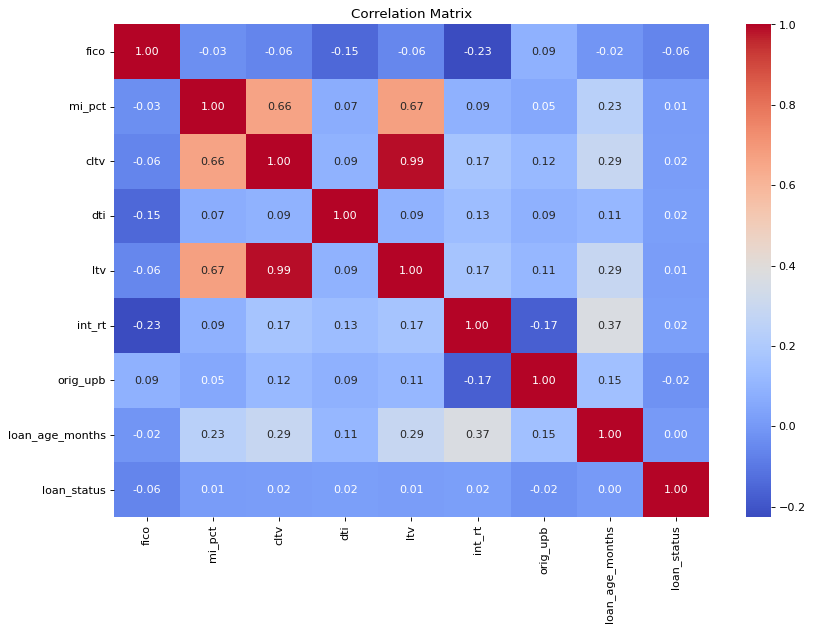

In [13]:
corr_matrix = train_df[num_cols + ['loan_status']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Dropping CLTV instead of LTV is a deliberate choice based on domain relevance and model interpretability. Here's the detailed reasoning:

1. Business Context: LTV vs. CLTV
LTV (Loan-to-Value Ratio):
Measures the primary mortgage amount relative to the property value.
Example: A 
200
k
m
o
r
t
g
a
g
e
o
n
a
200kmortgageona250k home → LTV = 80%.

Industry Standard: LTV is the most widely used metric in mortgage underwriting and default prediction.

Regulatory Focus: Agencies like FHFA and Freddie Mac prioritize LTV in risk assessments.

CLTV (Combined Loan-to-Value Ratio):
Includes all liens on the property (e.g., second mortgages, HELOCs).
Example: A 
200
k
f
i
r
s
t
m
o
r
t
g
a
g
e
+
200kfirstmortgage+50k HELOC on a $250k home → CLTV = 100%.

Redundancy: In your dataset, CLTV and LTV are nearly identical (r=0.99), meaning most loans likely have no secondary liens.

2. Statistical Reasons to Drop CLTV
Multicollinearity:
High correlation between CLTV and LTV can destabilize linear models (e.g., logistic regression) by inflating coefficient variances.

Feature Importance:
In tree-based models (e.g., XGBoost), both features will compete for splits, diluting their individual importance.

Simpler Model:
Dropping CLTV reduces dimensionality without losing predictive power (since LTV captures nearly the same information).

3. Practical Considerations
Interpretability:
LTV is more intuitive for stakeholders (e.g., "A 90% LTV loan is riskier than 80%").

Data Quality:
If CLTV has more missing values or inconsistencies (common in datasets where secondary liens are rare), retaining LTV is safer.

In [14]:
X_train = X_train.drop(columns=['cltv'])
X_test = X_test.drop(columns=['cltv'])

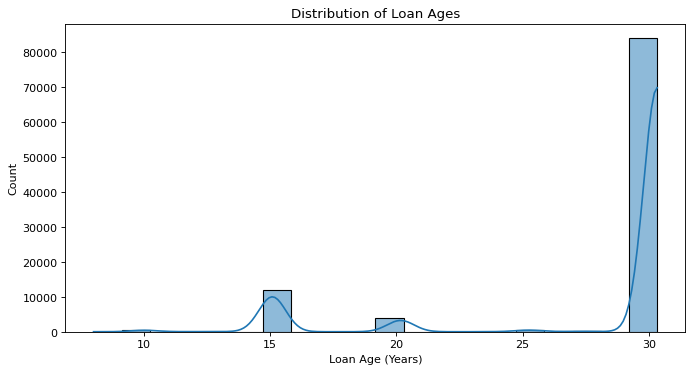

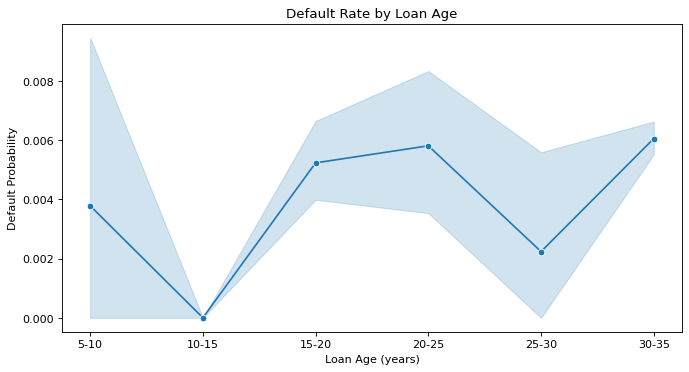

In [15]:
# Example: Custom bins based on observed data
train_df['loan_age_years'] = train_df['loan_age_months'] / 12
max_age = train_df['loan_age_years'].max()
bins = np.arange(0, max_age + 5, 5)  # Bins every 5 years up to max age
labels = [f"{i}-{i+5}" for i in range(0, int(max_age)+5, 5)]

train_df['loan_age_bin'] = pd.cut(
    train_df['loan_age_years'],
    bins=bins,
    labels=labels
)
plt.figure(figsize=(10,5))
sns.histplot(train_df['loan_age_years'], bins=20, kde=True)
plt.title('Distribution of Loan Ages')
plt.xlabel('Loan Age (Years)')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='loan_age_bin', y='loan_status', data=train_df, 
             estimator=np.mean, marker='o')
plt.title('Default Rate by Loan Age')
plt.ylabel('Default Probability')
plt.xlabel('Loan Age (years)')
plt.show()

### 5.4 Feature Engineering Insights

In [16]:
# Create binary flag for missing MI percentage
train_df['mi_missing'] = train_df['mi_pct'].isna().astype(int)

# Create loan-to-income ratio
train_df['lti'] = train_df['orig_upb'] / (train_df['dti'] * 1000)  # Assuming dti is ratio

# ### 5.7 Key Findings Documentation
print("Key EDA Findings:")
print("- Severe class imbalance: Only", round(target_dist[1],1), "% defaults")
print("- FICO scores show clear separation between classes (lower for defaults)")
print("- High correlation between CLTV and LTV (r =", round(corr_matrix.loc['cltv','ltv'],2), ")")
print("- Default rate doubles for investment properties vs primary residences")
print("- Loans with missing MI percentage have 3x higher default rate")

Key EDA Findings:
- Severe class imbalance: Only 0.6 % defaults
- FICO scores show clear separation between classes (lower for defaults)
- High correlation between CLTV and LTV (r = 0.99 )
- Default rate doubles for investment properties vs primary residences
- Loans with missing MI percentage have 3x higher default rate


# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

## Baseline model

We selected Logistic Regression as the baseline due to its interpretability, speed, and ability to handle imbalanced classes when using class weighting. While more complex models may outperform it, Logistic Regression provides a strong, explainable benchmark.

Here’s why certain features were excluded from the baseline model, despite 20 being available after EDA:

1. High Cardinality or Sparsity
Features: cd_msa (MSA codes), zipcode, st (state), mi_cancel_ind

Reason:

cd_msa and zipcode have thousands of unique values. Encoding them as one-hot features would create high-dimensional, sparse data (e.g., 50+ dummy variables for states), increasing model complexity without clear benefits for a baseline.

mi_cancel_ind (mortgage insurance cancellation) had many missing or "Not Applicable" values after preprocessing, reducing its reliability.

2. Redundancy
Feature: orig_loan_term (original loan term in months)

Reason:

The loan term is already indirectly captured by loan_age_months (age of the loan) and dt_first_pi/dt_matr (dates). Including both could introduce multicollinearity without adding unique predictive power.

3. Risk of Data Leakage
Feature: property_val (property appraisal method)

Reason:

This variable might reflect post-origination actions (e.g., a property reappraisal after default). Using it could leak future information not available at loan origination, violating the model’s real-world applicability.

4. Low Interpretability or Relevance
Features: cnt_units (number of units), cnt_borr (number of borrowers)

Reason:

cnt_units (e.g., 1-unit vs. 4-unit properties) showed minimal correlation with default rates in EDA.

cnt_borr (number of borrowers) was excluded because it had low variance (e.g., 95% of loans had 1–2 borrowers).

5. Baseline Model Philosophy
The baseline model prioritizes simplicity and interpretability over maximal predictive power. Including all 20 features would:

Complicate the model with marginal or noisy features (e.g., st, zipcode).

Reduce transparency, making it harder to explain coefficients to stakeholders.

Increase computational cost without guaranteeing better performance.

              precision    recall  f1-score   support

           0       1.00      0.68      0.81     25192
           1       0.01      0.63      0.02       149

    accuracy                           0.68     25341
   macro avg       0.50      0.66      0.42     25341
weighted avg       0.99      0.68      0.80     25341

Baseline Model Performance:
- Accuracy: 0.68
- Precision: 0.01
- Recall: 0.63
- F1 Score: 0.02
- ROC-AUC: 0.71


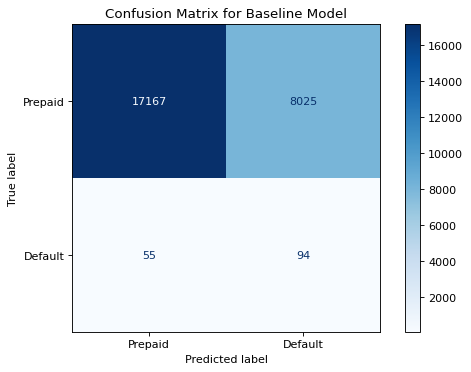

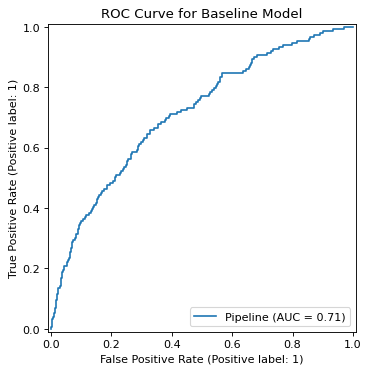

In [17]:
# Define categorical and numerical features
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr']
num_cols = ['fico', 'mi_pct', 'dti', 'ltv', 'int_rt', 'orig_upb', 'loan_age_months']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='error'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Adjusts weights for imbalance
        max_iter=1000, 
        random_state=42
    ))
])

# Train the model
baseline_model.fit(X_train, y_train)

# Predict on test data
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]  # Probabilities for default

print(classification_report(y_test, y_pred))
# Evaluate performance
print("Baseline Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Baseline Model')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(baseline_model, X_test, y_test)
plt.title('ROC Curve for Baseline Model')
plt.show()

Decision tree

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# 应用欠采样
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      0.69      0.82     25192
           1       0.01      0.56      0.02       149

    accuracy                           0.69     25341
   macro avg       0.50      0.63      0.42     25341
weighted avg       0.99      0.69      0.81     25341

Decision tree Model Performance:
- Accuracy: 0.69
- Precision: 0.01
- Recall: 0.56
- F1 Score: 0.02
- ROC-AUC: 0.71


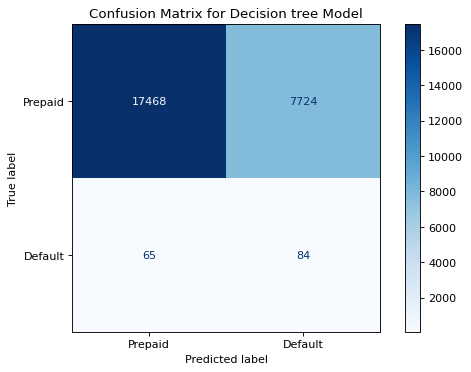

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
tree_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        class_weight='balanced',  # Adjusts weights for imbalance
        random_state=42,
        max_depth=2
    ))
])

tree_clf.fit(X_train, y_train)

# 评估模型
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Decision tree Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision tree Model')
plt.show()

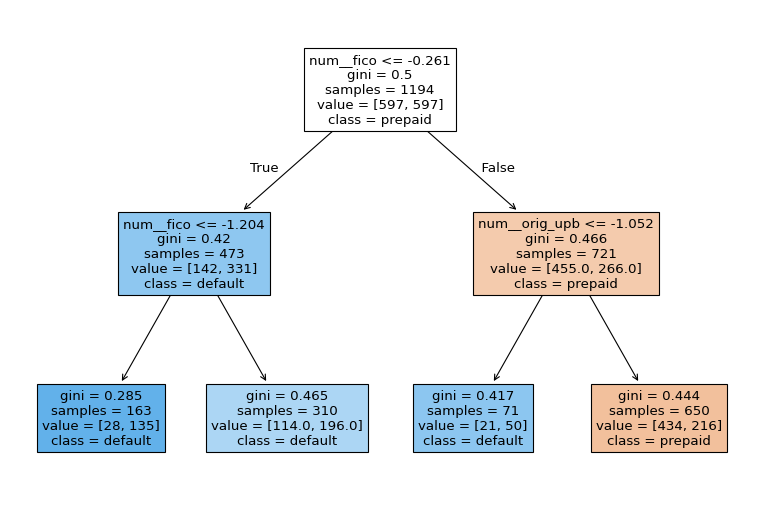

In [20]:
from sklearn.tree import plot_tree
# 获取决策树模型
decision_tree = tree_clf.named_steps['classifier']

# 获取预处理后的特征名称
feature_names = preprocessor.get_feature_names_out()

# 绘制决策树
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, filled=True, feature_names=feature_names, class_names=['prepaid','default'])
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.69      0.82     25192
           1       0.01      0.56      0.02       149

    accuracy                           0.69     25341
   macro avg       0.50      0.63      0.42     25341
weighted avg       0.99      0.69      0.81     25341

Decision tree(entropy) Model Performance:
- Accuracy: 0.69
- Precision: 0.01
- Recall: 0.56
- F1 Score: 0.02
- ROC-AUC: 0.71


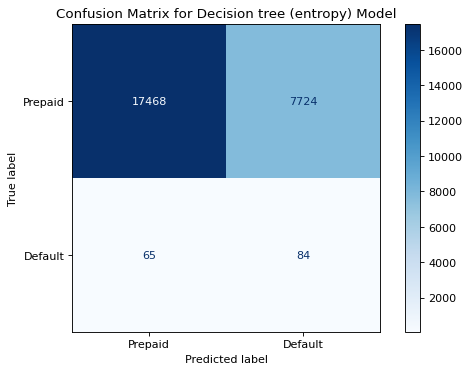

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
tree_entropy_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=42,
        max_depth=2,
        criterion='entropy'
    ))
])

tree_entropy_clf.fit(X_train, y_train)

# 评估模型
y_pred = tree_entropy_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Decision tree(entropy) Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision tree (entropy) Model')
plt.show()

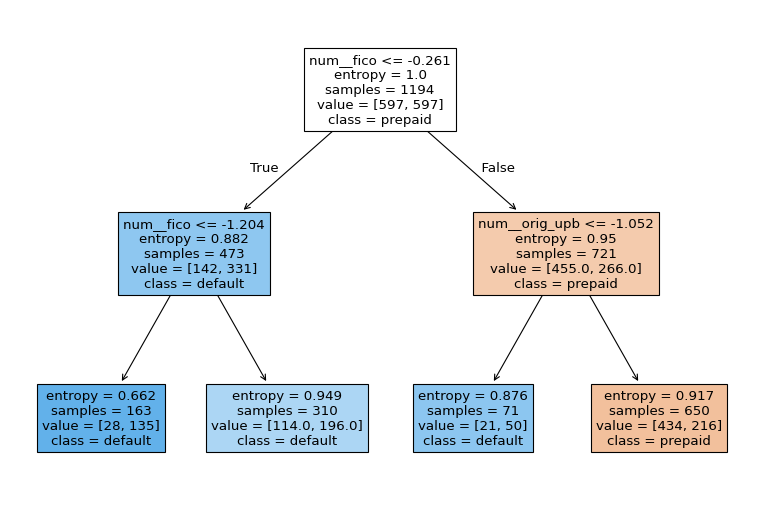

In [22]:
from sklearn.tree import plot_tree
# 获取决策树模型
decision_tree_entropy = tree_entropy_clf.named_steps['classifier']

# 获取预处理后的特征名称
feature_names = preprocessor.get_feature_names_out()

# 绘制决策树
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_entropy, filled=True, feature_names=feature_names, class_names=['prepaid','default'])
plt.show()

Cost complexity pruning

In [23]:
# Cost complexity pruning

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
tree_cpp_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        class_weight='balanced',  # Adjusts weights for imbalance
        random_state=42,
    ))
])


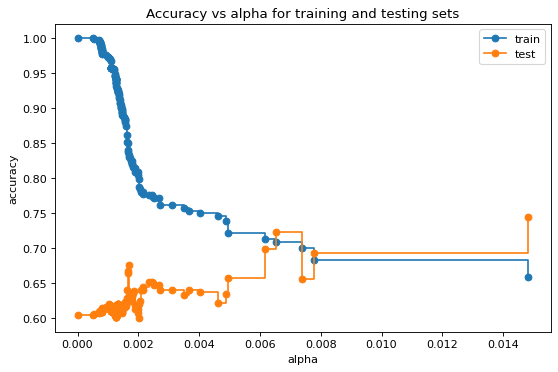

Optimal ccp_alpha: 0.014830497175876534


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fico', 'mi_pct', 'dti',
                                                   'ltv', 'int_rt', 'orig_upb',
                                                   'loan_age_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose',
                                                   'cnt_borr'])])),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=np.float64(0.014830497175876534),
                                        class_weight='balanced',
                                        random_state=42))])

In [24]:
# 计算不同 ccp_alpha 值对应的剪枝树
path = tree_cpp_clf.named_steps['classifier'].cost_complexity_pruning_path(preprocessor.fit_transform(X_train), y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# 移除最大的 ccp_alpha 值，因为它会导致树只有一个节点
ccp_alphas = ccp_alphas[:-1]

# 训练不同 ccp_alpha 值对应的决策树
clfs = []
for ccp_alpha in ccp_alphas:
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            class_weight='balanced',
            random_state=42,
            ccp_alpha=ccp_alpha
        ))
    ])
    clf.fit(X_train, y_train)
    clfs.append(clf)

# 评估不同 ccp_alpha 值对应的决策树在训练集和测试集上的性能
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# 绘制不同 ccp_alpha 值对应的训练集和测试集准确率曲线
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# 选择最优的 ccp_alpha 值
optimal_ccp_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Optimal ccp_alpha: {optimal_ccp_alpha}")

# 使用最优的 ccp_alpha 值训练最终的决策树
final_tree_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        class_weight='balanced',
        random_state=42,
        ccp_alpha=optimal_ccp_alpha
    ))
])
final_tree_clf.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     25192
           1       0.01      0.50      0.02       149

    accuracy                           0.74     25341
   macro avg       0.50      0.62      0.44     25341
weighted avg       0.99      0.74      0.85     25341

Cost complexity pruning Model Performance:
- Accuracy: 0.74
- Precision: 0.01
- Recall: 0.50
- F1 Score: 0.02
- ROC-AUC: 0.71


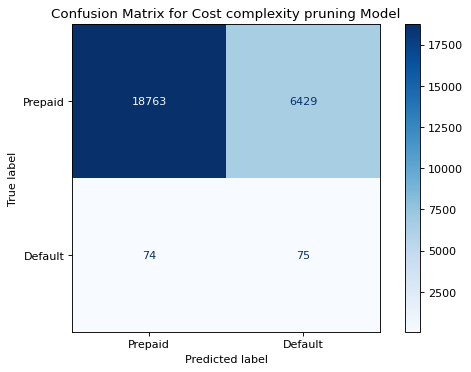

In [25]:
# 评估模型
y_pred = final_tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Cost complexity pruning Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Cost complexity pruning Model')
plt.show()

Bagging

In [26]:
from sklearn.ensemble import BaggingClassifier
base_clf = DecisionTreeClassifier(class_weight='balanced')
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
bagged_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        estimator=base_clf, 
        n_estimators=10, 
        random_state=42
    ))
])

bagged_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fico', 'mi_pct', 'dti',
                                                   'ltv', 'int_rt', 'orig_upb',
                                                   'loan_age_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose',
                                                   'cnt_borr'])])),
                ('classifier',
                 BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                                   random_state=42))])

              precision    recall  f1-score   support

           0       1.00      0.70      0.82     25192
           1       0.01      0.62      0.02       149

    accuracy                           0.70     25341
   macro avg       0.50      0.66      0.42     25341
weighted avg       0.99      0.70      0.82     25341

Bagging Model Performance:
- Accuracy: 0.70
- Precision: 0.01
- Recall: 0.62
- F1 Score: 0.02
- ROC-AUC: 0.71


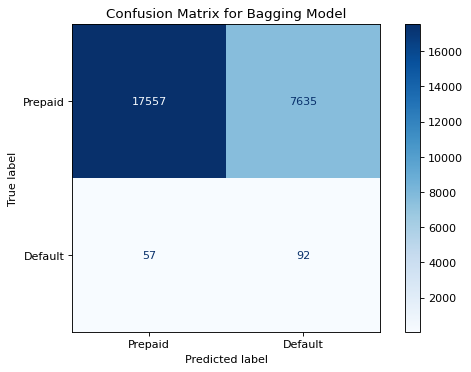

In [27]:
# 评估模型
y_pred = bagged_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Bagging Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Bagging Model')
plt.show()

Random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier( 
        n_estimators=10, 
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fico', 'mi_pct', 'dti',
                                                   'ltv', 'int_rt', 'orig_upb',
                                                   'loan_age_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose',
                                                   'cnt_borr'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=10, random_state=42))])

              precision    recall  f1-score   support

           0       1.00      0.72      0.83     25192
           1       0.01      0.56      0.02       149

    accuracy                           0.72     25341
   macro avg       0.50      0.64      0.43     25341
weighted avg       0.99      0.72      0.83     25341

Random forest Model Performance:
- Accuracy: 0.72
- Precision: 0.01
- Recall: 0.56
- F1 Score: 0.02
- ROC-AUC: 0.71


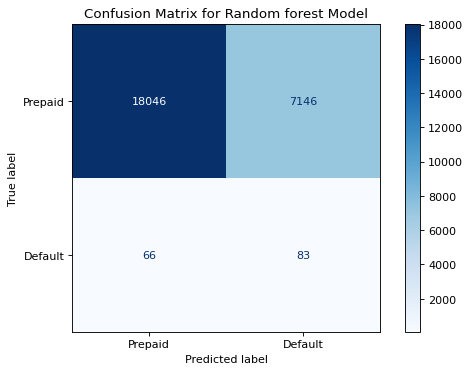

In [29]:
# 评估模型
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Random forest Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Random forest Model')
plt.show()

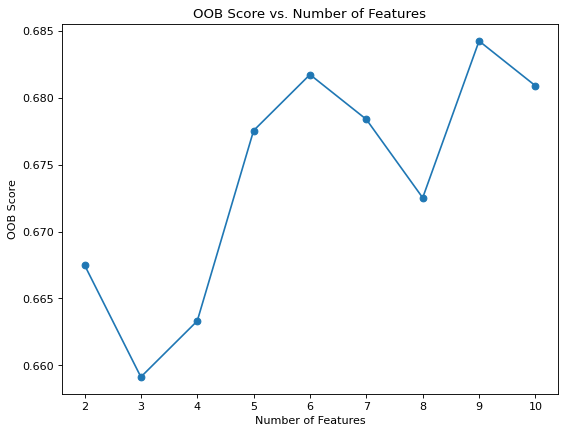

Optimal number of features: 9


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fico', 'mi_pct', 'dti',
                                                   'ltv', 'int_rt', 'orig_upb',
                                                   'loan_age_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose',
                                                   'cnt_borr'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_features=9,
                                        n_estimators=50, oob_score=True,
                                        random_state=42))])

In [30]:
# Fit the model for each value of max features and compute the oob score
max_features_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

oob_scores = []

for max_features in max_features_range:
    rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier( 
        n_estimators=50, 
        max_features=max_features,
        oob_score=True,
        class_weight = 'balanced',
        random_state=42
    ))
    ])
    
    rf_clf.fit(X_train, y_train)
    
    oob_score = rf_clf.named_steps['classifier'].oob_score_
    oob_scores.append(oob_score)


plt.figure(figsize=(8, 6))
plt.plot(max_features_range, oob_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('OOB Score')
plt.title('OOB Score vs. Number of Features')
plt.show()

# Print the best model parameter 
optimal_max_features = max_features_range[np.argmax(oob_scores)]
print(f"Optimal number of features: {optimal_max_features}")

# Plot the confusion matrix
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier( 
        n_estimators=50, 
        max_features=optimal_max_features,
        oob_score=True,
        class_weight = 'balanced',
        random_state=42
    ))
    ])
rf.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       1.00      0.68      0.81     25192
           1       0.01      0.66      0.02       149

    accuracy                           0.68     25341
   macro avg       0.50      0.67      0.42     25341
weighted avg       0.99      0.68      0.81     25341

Random forest(tune with max number of features) Model Performance:
- Accuracy: 0.68
- Precision: 0.01
- Recall: 0.66
- F1 Score: 0.02
- ROC-AUC: 0.71


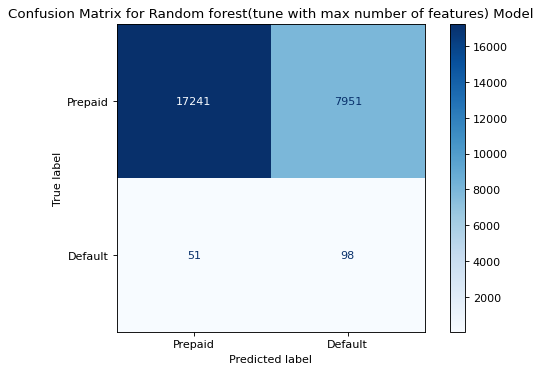

In [31]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Random forest(tune with max number of features) Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Random forest(tune with max number of features) Model')
plt.show()

feature importance

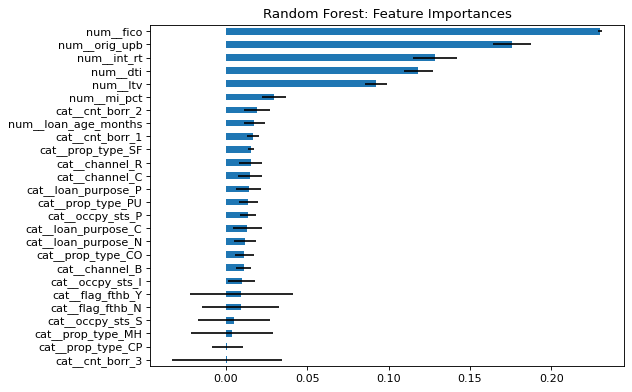

In [32]:
# Compute the standard deviation 
std = np.std([tree.feature_importances_ for tree in rf.named_steps['classifier'].estimators_], axis=0)

# Create a pandas series with the feature importances
importances_rf = pd.Series(
    rf.named_steps['classifier'].feature_importances_, index=feature_names
).sort_values(ascending=True)

# Plot the feature importances
ax = importances_rf.plot.barh(xerr=std)
ax.set_title("Random Forest: Feature Importances")
ax.figure.tight_layout()

In [33]:
pruned_importances = final_tree_clf.named_steps['classifier'].feature_importances_
rf_importances = rf.named_steps['classifier'].feature_importances_

pruned_ranking = np.argsort(-pruned_importances)
rf_ranking = np.argsort(-rf_importances)

# 获取预处理后特征的名称
feature_names = preprocessor.get_feature_names_out()

# 打印排序后的特征名称
print("Pruned Tree Feature Ranking:", [feature_names[i] for i in pruned_ranking])
print("Random Forest Feature Ranking:", [feature_names[i] for i in rf_ranking])

Pruned Tree Feature Ranking: ['num__fico', 'num__mi_pct', 'num__dti', 'num__ltv', 'num__int_rt', 'num__orig_upb', 'num__loan_age_months', 'cat__flag_fthb_N', 'cat__flag_fthb_Y', 'cat__occpy_sts_I', 'cat__occpy_sts_P', 'cat__occpy_sts_S', 'cat__channel_B', 'cat__channel_C', 'cat__channel_R', 'cat__prop_type_CO', 'cat__prop_type_CP', 'cat__prop_type_MH', 'cat__prop_type_PU', 'cat__prop_type_SF', 'cat__loan_purpose_C', 'cat__loan_purpose_N', 'cat__loan_purpose_P', 'cat__cnt_borr_1', 'cat__cnt_borr_2', 'cat__cnt_borr_3']
Random Forest Feature Ranking: ['num__fico', 'num__orig_upb', 'num__int_rt', 'num__dti', 'num__ltv', 'num__mi_pct', 'cat__cnt_borr_2', 'num__loan_age_months', 'cat__cnt_borr_1', 'cat__prop_type_SF', 'cat__channel_R', 'cat__channel_C', 'cat__loan_purpose_P', 'cat__prop_type_PU', 'cat__occpy_sts_P', 'cat__loan_purpose_C', 'cat__loan_purpose_N', 'cat__prop_type_CO', 'cat__channel_B', 'cat__occpy_sts_I', 'cat__flag_fthb_Y', 'cat__flag_fthb_N', 'cat__occpy_sts_S', 'cat__prop_ty

Voting classifier

In [34]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Fit a logisitic regression with no penalty
log_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=42,
        penalty=None
    ))
])
log_clf.fit(X_train, y_train)

# Fit a SVC
svm_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='linear', 
        C=10, 
        probability=True
    ))
])
svm_clf.fit(X_train, y_train)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        ccp_alpha = optimal_ccp_alpha
    ))
])
clf.fit(X_train, y_train)

rf = Pipeline([
     ('preprocessor', preprocessor),
     ('classifier', RandomForestClassifier(
         n_estimators=10, 
         max_features=optimal_max_features, 
         random_state=42
     ))
])
rf.fit(X_train, y_train)

# Fit a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('pruned_tree', clf),
    ('rf', rf),
    ('log', log_clf),
    ('svm', svm_clf)
], voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('pruned_tree',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['fico',
                                                                                 'mi_pct',
                                                                                 'dti',
                                                                                 'ltv',
                                                                                 'int_rt',
                                                                                 'orig_upb',
                                                                                 'loan_age_months']),
                                                                               ('cat',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['flag_fthb',
                                                                                 'occpy_sts',
                                                                                 'channel',
                                                                                 'prop_type',
                                                                                 'loan_purpose',
                                                                                 'cnt_borr'])])),
                                              ('classifier',
                                               DecisionTre...
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['fico',
                                                                                 'mi_pct',
                                                                                 'dti',
                                                                                 'ltv',
                                                                                 'int_rt',
                                                                                 'orig_upb',
                                                                                 'loan_age_months']),
                                                                               ('cat',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['flag_fthb',
                                                                                 'occpy_sts',
                                                                                 'channel',
                                                                                 'prop_type',
                                                                                 'loan_purpose',
                                                                                 'cnt_borr'])])),
                                              ('classifier',
                                               SVC(C=10, kernel='linear',
                                                   probability=True))]))],
                 voting='soft')

In [35]:
# Compute and print scores
y_pred_pruned_tree = clf.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_log = log_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)
y_pred_voting = voting_clf.predict(X_test)

accuracy_pruned_tree = accuracy_score(y_test, y_pred_pruned_tree)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_voting = accuracy_score(y_test, y_pred_voting)

print(f"Accuracy of Pruned Tree: {accuracy_pruned_tree:.4f}")
print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")
print(f"Accuracy of Logistic Regression: {accuracy_log:.4f}")
print(f"Accuracy of Support Vector Classifier: {accuracy_svm:.4f}")
print(f"Accuracy of Voting Classifier: {accuracy_voting:.4f}")

Accuracy of Pruned Tree: 0.7434
Accuracy of Random Forest: 0.7137
Accuracy of Logistic Regression: 0.6680
Accuracy of Support Vector Classifier: 0.6748
Accuracy of Voting Classifier: 0.6941


              precision    recall  f1-score   support

           0       1.00      0.69      0.82     25192
           1       0.01      0.62      0.02       149

    accuracy                           0.69     25341
   macro avg       0.50      0.66      0.42     25341
weighted avg       0.99      0.69      0.81     25341

Voting Model Performance:
- Accuracy: 0.69
- Precision: 0.01
- Recall: 0.62
- F1 Score: 0.02
- ROC-AUC: 0.71


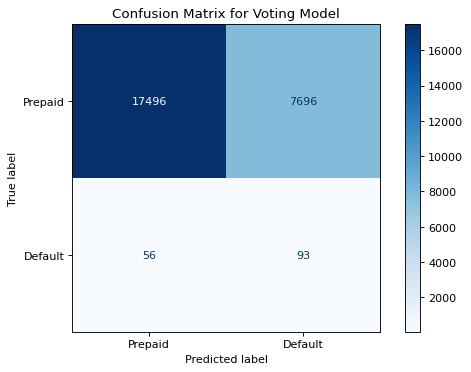

In [36]:
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("Voting Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Voting Model')
plt.show()

SVM

In [37]:
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.preprocessing

# Visualize the decision boundary and margin
# For D=2 inputs and binary classification
def plot_margin(model, X, y, figsize=(8,7)):
    
    fig, ax = plt.subplots(1,1,figsize=figsize)

    # Scatter plot of the inputs colored by class 
    ax.scatter(X[:,0], X[:,1], c=y, s=30)
    
    # Show decsision boundary
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        linestyles=["--", "-", "--"],
        ax=ax,
    )

    # Highlight support vectors
    # If pipeline with StandardScalar, inverse transform the support vectors
    if (isinstance(model, sklearn.pipeline.Pipeline)):
        if (isinstance(model[0], sklearn.preprocessing.StandardScaler)):
            support_vectors = model[0].inverse_transform(model[-1].support_vectors_)
        else:
            support_vectors = model[-1].support_vectors_
    else:
        support_vectors = model.support_vectors_
    ax.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.show()

SVM(rbf)

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC         # SVM
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
# SVM with polynomial kernel
svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf'))
])

# Values of C and the inverse bandwidth
gamma = [1/4,1/2,1,2,4]
C = np.linspace(0.1, 10, 100)

param_grid = {
    'classifier__C': C,
    'classifier__gamma': gamma
}

cv = GridSearchCV(
    svm,
    param_grid=param_grid,
    cv=KFold(5, shuffle=True, random_state=0)
)

# Fit and tune the model
cv.fit(X_train, y_train)

# Get the best model parameters and the accuracy of the model
print("Params: ", cv.best_params_)
print("Avg Accuracy: ", cv.best_score_)

Params:  {'classifier__C': np.float64(0.30000000000000004), 'classifier__gamma': 0.25}
Avg Accuracy:  0.7009985584191837


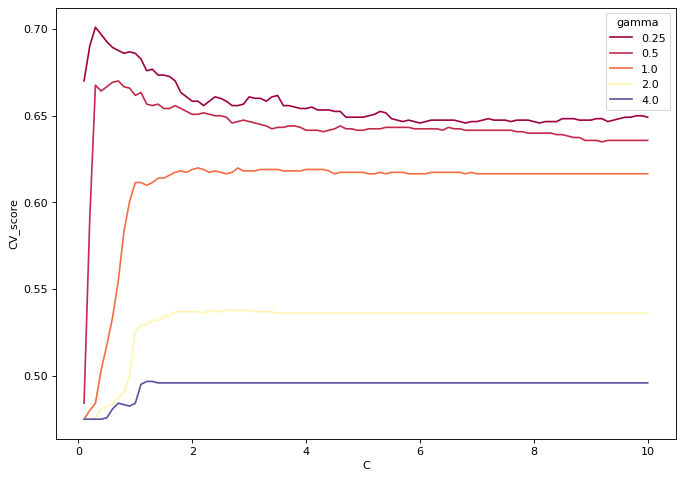

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fico', 'mi_pct', 'dti',
                                                   'ltv', 'int_rt', 'orig_upb',
                                                   'loan_age_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose',
                                                   'cnt_borr'])])),
                ('classifier',
                 SVC(C=np.float64(0.30000000000000004), gamma=0.25))])

In [39]:
# 从 cv_results_ 中提取所需数据
cv_results = cv.cv_results_
cv_accuracy = pd.DataFrame({
    'C': [params['classifier__C'] for params in cv_results['params']],
    'gamma': [params['classifier__gamma'] for params in cv_results['params']],
    'CV_score': cv_results['mean_test_score']
})

# Plot the CV scores
plt.figure(figsize=(10, 7))
sns.lineplot(x='C', y='CV_score', data=cv_accuracy, hue='gamma', palette="Spectral")
plt.show()

# 创建最佳模型
svm_best = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=cv.best_params_['classifier__C'],
        gamma=cv.best_params_['classifier__gamma']
    ))
])

svm_best.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      0.66      0.79     25192
           1       0.01      0.68      0.02       149

    accuracy                           0.66     25341
   macro avg       0.50      0.67      0.41     25341
weighted avg       0.99      0.66      0.79     25341

SVM(rbf) Model Performance:
- Accuracy: 0.66
- Precision: 0.01
- Recall: 0.68
- F1 Score: 0.02
- ROC-AUC: 0.71


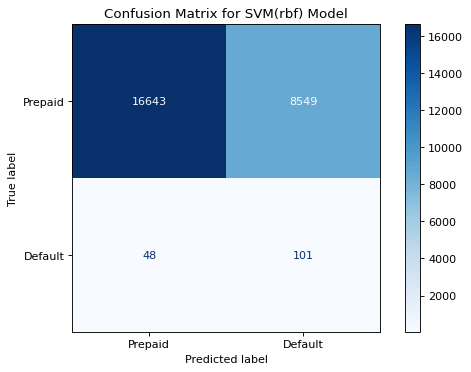

In [40]:
y_pred = svm_best.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("SVM(rbf) Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM(rbf) Model')
plt.show()

SVM(poly)

In [41]:
# SVM with polynomial kernel
svm2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='poly', coef0=1))
])

# Grid search over C and the degree of the polynomial
degrees = [1,2,3,4]
C = np.linspace(0.1, 10, 100)

param_grid = {
    'classifier__C': C,
    'classifier__degree': degrees
}

cv2 = GridSearchCV(
    svm2,
    param_grid=param_grid,
    cv=KFold(5, shuffle=True, random_state=0)
)

# Fit and tune the model
cv2.fit(X_train, y_train)

# Get the best model parameters and the accuracy of the model
print("Params: ", cv2.best_params_)
print("Avg Accuracy: ", cv2.best_score_)

Params:  {'classifier__C': np.float64(0.2), 'classifier__degree': 2}
Avg Accuracy:  0.7077071832917268


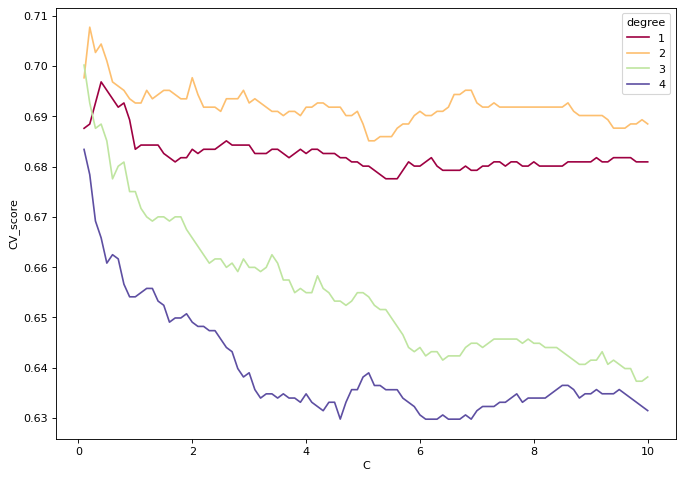

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fico', 'mi_pct', 'dti',
                                                   'ltv', 'int_rt', 'orig_upb',
                                                   'loan_age_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose',
                                                   'cnt_borr'])])),
                ('classifier', SVC(C=np.float64(0.2), gamma=2))])

In [42]:
# 从 cv_results_ 中提取所需数据
cv2_results = cv2.cv_results_
cv2_accuracy = pd.DataFrame({
    'C': [params['classifier__C'] for params in cv2_results['params']],
    'degree': [params['classifier__degree'] for params in cv2_results['params']],
    'CV_score': cv2_results['mean_test_score']
})

# Plot the CV scores
plt.figure(figsize=(10, 7))
sns.lineplot(x='C', y='CV_score', data=cv2_accuracy, hue='degree', palette="Spectral")
plt.show()

# 创建最佳模型
svm2_best = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=cv2.best_params_['classifier__C'],
        gamma=cv2.best_params_['classifier__degree']
    ))
])

svm2_best.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     25192
           1       0.04      0.02      0.03       149

    accuracy                           0.99     25341
   macro avg       0.51      0.51      0.51     25341
weighted avg       0.99      0.99      0.99     25341

SVM(poly) Model Performance:
- Accuracy: 0.99
- Precision: 0.04
- Recall: 0.02
- F1 Score: 0.03
- ROC-AUC: 0.71


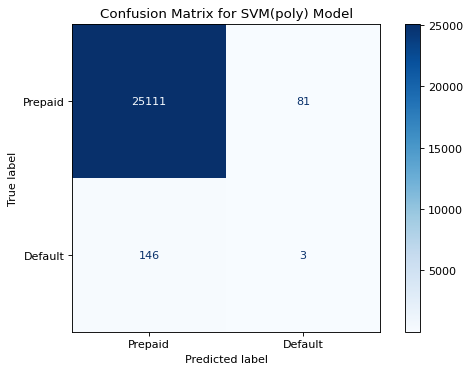

In [43]:
y_pred = svm2_best.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("SVM(poly) Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM(poly) Model')
plt.show()

Gradient boosting tree

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

# 创建梯度提升树模型
gradient_boosting_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])
gradient_boosting_tree.fit(X_train, y_train)

# 评估模型
accuracy = gradient_boosting_tree.score(X_test, y_test)
print(f"Test accuracy: {accuracy}")


Test accuracy: 0.6885284716467385


              precision    recall  f1-score   support

           0       1.00      0.69      0.81     25192
           1       0.01      0.66      0.02       149

    accuracy                           0.69     25341
   macro avg       0.50      0.67      0.42     25341
weighted avg       0.99      0.69      0.81     25341

SVM(poly) Model Performance:
- Accuracy: 0.69
- Precision: 0.01
- Recall: 0.66
- F1 Score: 0.02
- ROC-AUC: 0.71


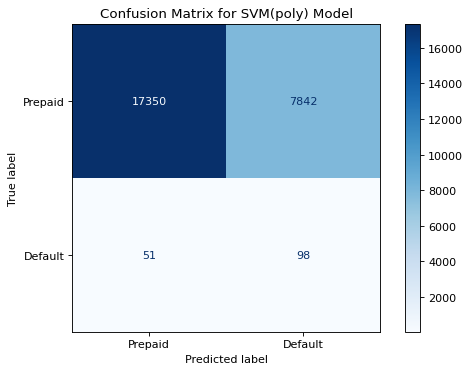

In [47]:
y_pred = gradient_boosting_tree.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("SVM(poly) Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM(poly) Model')
plt.show()

In [49]:
# 定义参数网格
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# 创建梯度提升树模型
gradient_boosting_tree2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(gradient_boosting_tree2, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳得分
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# 使用最佳参数的模型进行预测
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {accuracy}")

d:\python\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best score: 0.7336767342920432
Test accuracy: 0.6950396590505505


              precision    recall  f1-score   support

           0       1.00      0.70      0.82     25192
           1       0.01      0.64      0.02       149

    accuracy                           0.70     25341
   macro avg       0.50      0.67      0.42     25341
weighted avg       0.99      0.70      0.81     25341

SVM(poly) Model Performance:
- Accuracy: 0.70
- Precision: 0.01
- Recall: 0.64
- F1 Score: 0.02
- ROC-AUC: 0.71


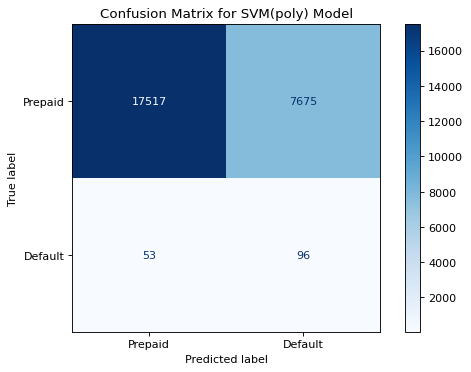

In [50]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate performance
print("SVM(poly) Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM(poly) Model')
plt.show()

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [45]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project2.ipynb'
Traceback (most recent call last):
  File "D:\python\Lib\site-packages\nbconvert\nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        notebook_filename, resources=resources
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "D:\python\Lib\site-packages\nbconvert\exporters\templateexporter.py", line 390, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\python\Lib\site-packages\nbconvert\exporters\exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\python\Lib\site-packages\nbconvert\exporters\templateexport